# 一 手动生成回归任务的数据集

## 0 数据生成

In [13]:
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
import matplotlib.pyplot as plt

devc = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 参数设置
seed = 114514
n_train = 7000
n_test = 3000
mean = 0
std = 0.1
p = 500
h = 50
intercept = 0.028
coef = 0.0056

In [14]:
def generate_data(seed, n_train, n_test, mean, std, p, h, intercept, coef):

    # 设置随机种子以确保可重复性
    torch.manual_seed(seed)

    # 参数设置
    n_total = n_train + n_test  # 总样本数

    # 生成特征 X：形状为 (n_total, p)，从标准正态分布采样
    X = torch.randn(n_total, p, device=devc)

    # 使用矩阵乘法高效计算线性组合
    weights = torch.full((p, 1), coef, device=devc)
    y_true = intercept + X @ weights
    noise = torch.normal(mean=mean, std=std, size=(n_total, 1), device=devc)
    y = y_true + noise

    # 划分训练集和测试集
    X_train = X[:n_train]
    X_test = X[n_train:]
    y_train = y[:n_train]
    y_test = y[n_train:]

    return X_train, y_train, X_test, y_test


X_train, y_train, X_test, y_test = generate_data(
    seed=seed,
    n_train=n_train,
    n_test=n_test,
    mean=mean,
    std=std,
    p=p,
    h=h,
    intercept=intercept,
    coef=coef,
)


def train_iter(batch_size, features=X_train, labels=y_train):
    num_examples = len(features)
    indicies = torch.randperm(num_examples, device=devc)
    for i in range(0, num_examples, batch_size):
        batch_index = indicies[i : min(i + batch_size, num_examples)]
        yield features.index_select(0, batch_index), labels.index_select(0, batch_index)


def test_iter(batch_size, features=X_test, labels=y_test):
    num_examples = len(features)
    indicies = torch.arange(num_examples, device=devc)
    for i in range(0, num_examples, batch_size):
        batch_index = indicies[i : min(i + batch_size, num_examples)]
        yield features.index_select(0, batch_index), labels.index_select(0, batch_index)

## 1 ⼿动实现前馈神经⽹络解决上述回归、⼆分类、多分类任务
分析实验结果并绘制训练集和测试集的loss曲线

In [15]:
# 模型
def net_MLP_linearRegression(X, w1, w2, b1, b2):
    z0 = X
    z1 = z0 @ w1 + b1
    y1 = torch.relu(z1)
    z2 = y1 @ w2 + b2
    # y2 = torch.relu(z2)
    # y_hat = y2
    y_hat = z2
    return y_hat


def net_fn(X, w1, w2, b1, b2):
    return net_MLP_linearRegression(X, w1, w2, b1, b2)

In [16]:
# 损失
def loss_mse(y_hat, y):
    loss_val = torch.mean((y_hat - y) ** 2)
    return loss_val


def loss_fn(y_hat, y):
    return loss_mse(y_hat, y)

In [17]:
# 优化
def optim_sgd(params, lr):
    with torch.no_grad():
        for param in params:
            param.data -= lr * param.grad
            param.grad.zero_()


def optim_fn(params, lr):
    return optim_sgd(params, lr)

In [18]:
# 评估
def eval_loss_fn(w1, w2, b1, b2, data_iter, batch_size):
    with torch.no_grad():
        loss_val = 0
        total_samples = 0
        for X_batch, y_batch in data_iter(batch_size=batch_size):
            y_hat = net_fn(X_batch, w1, w2, b1, b2)
            loss_val += loss_fn(y_hat, y_batch).item() * len(y_batch)
            total_samples += len(y_batch)
        loss_val /= total_samples
        return loss_val

In [19]:
# 训练
def train(
    train_iter,
    net_fn,
    loss_fn,
    optim_fn,
    w1,
    w2,
    b1,
    b2,
    lr,
    num_epochs,
    batch_size,
    test_iter,
    eval_loss_fn,
):
    # 日志信息
    train_loss_list, test_loss_list = [], []

    for epoch in range(num_epochs):
        # 日志信息参数
        total_examples = 0
        train_loss_val, test_loss_val = 0, 0

        for X_batch, y_batch in train_iter(batch_size=batch_size):
            X_batch, y_batch = X_batch.to(devc), y_batch.to(devc)
            # forward
            y_hat = net_fn(X_batch, w1, w2, b1, b2)
            loss_val = loss_fn(y_hat, y_batch)
            # backward
            loss_val.backward()
            with torch.no_grad():
                # update and clear
                optim_fn([w1, w2, b1, b2], lr)

                # 计算日志信息
                total_examples += len(y_batch)
                train_loss_val += loss_val.item() * len(y_batch)
        with torch.no_grad():
            train_loss_val /= total_examples
            train_loss_list.append(train_loss_val)
            test_loss_val = eval_loss_fn(w1, w2, b1, b2, test_iter, batch_size)
            test_loss_list.append(test_loss_val)
            print(
                f"epoch:{epoch+1},train_loss:{train_loss_val:.4f},test_loss:{test_loss_val:.4f}"
            )

    return w1, w2, b1, b2, train_loss_list, test_loss_list

epoch:1,train_loss:1.4974,test_loss:0.8624
epoch:2,train_loss:0.6480,test_loss:0.5051
epoch:3,train_loss:0.3851,test_loss:0.3438
epoch:4,train_loss:0.2623,test_loss:0.2528
epoch:5,train_loss:0.1926,test_loss:0.1961
epoch:6,train_loss:0.1488,test_loss:0.1576
epoch:7,train_loss:0.1193,test_loss:0.1299
epoch:8,train_loss:0.0984,test_loss:0.1092
epoch:9,train_loss:0.0828,test_loss:0.0933
epoch:10,train_loss:0.0710,test_loss:0.0810
epoch:11,train_loss:0.0618,test_loss:0.0717
epoch:12,train_loss:0.0547,test_loss:0.0634
epoch:13,train_loss:0.0489,test_loss:0.0573
epoch:14,train_loss:0.0444,test_loss:0.0519
epoch:15,train_loss:0.0407,test_loss:0.0476
epoch:16,train_loss:0.0377,test_loss:0.0441
epoch:17,train_loss:0.0352,test_loss:0.0411
epoch:18,train_loss:0.0331,test_loss:0.0387
epoch:19,train_loss:0.0315,test_loss:0.0367
epoch:20,train_loss:0.0301,test_loss:0.0349
epoch:21,train_loss:0.0289,test_loss:0.0335
epoch:22,train_loss:0.0279,test_loss:0.0323
epoch:23,train_loss:0.0271,test_loss:0.03

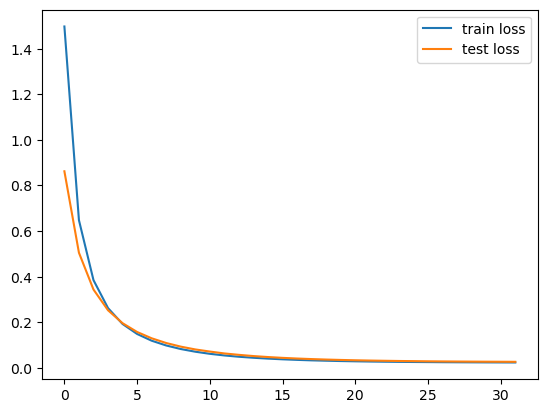

In [20]:
# 训练过程
lr = 0.03
num_epoches = 32
batch_size = 1024
# 对于ReLU激活函数，He初始化收敛更快(He初始化:mean=0,std=sqrd(2/n),n为当前层输入维数)
w1 = torch.normal(
    mean=0, std=(2 / p) ** 0.5, size=(p, h), requires_grad=True, device=devc
)
w2 = torch.normal(
    mean=0, std=(2 / h) ** 0.5, size=(h, 1), requires_grad=True, device=devc
)
b1 = torch.zeros(h, device=devc, requires_grad=True)
b2 = torch.zeros(1, device=devc, requires_grad=True)

w1, w2, b1, b2, train_loss_list, test_loss_list = train(
    train_iter,
    net_fn,
    loss_fn,
    optim_fn,
    w1,
    w2,
    b1,
    b2,
    lr,
    num_epoches,
    batch_size,
    test_iter,
    eval_loss_fn,
)

plt.plot(train_loss_list, label="train loss")
plt.plot(test_loss_list, label="test loss")
plt.legend()
plt.show()

## 2 利⽤torch.nn实现前馈神经⽹络解决上述回归、⼆分类、多分类任务
分析实验结果并绘制训练集和测试集的loss曲线

In [21]:
# 模型
class MLPRegression(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),  # 输出层线性，不加激活
        )

    def forward(self, x):
        return self.model(x)


def get_net_fn(input_dim, hidden_dim, device):
    net = MLPRegression(input_dim=input_dim, hidden_dim=hidden_dim).to(device)
    # 遍历网络每一层进行初始化
    for m in net.modules():
        if isinstance(m, nn.Linear):
            # 对隐藏层使用 He 初始化
            init.kaiming_normal_(m.weight, nonlinearity="relu")
            if m.bias is not None:
                init.zeros_(m.bias)
    return net

In [22]:
# 损失
def get_loss_fn():
    return nn.MSELoss()

In [23]:
# 优化器
def get_optim_fn(params, lr):
    return optim.SGD(params=params, lr=lr)

In [24]:
# 评估
def eval_loss_fn(net, loss, data_iter, batch_size):
    net.eval()
    with torch.no_grad():
        num_total = 0
        loss_val = 0
        for X_batch, y_batch in data_iter(batch_size=batch_size):
            X_batch, y_batch = X_batch.to(devc), y_batch.to(devc)

            y_hat = net(X_batch)
            num_total += len(y_batch)
            loss_val += loss(y_hat, y_batch.view(-1, 1)).item() * len(y_batch)
        loss_val /= num_total
    return loss_val

In [25]:
# 训练
def train(
    net,
    loss,
    optimizer,
    num_epoches,
    batch_size,
    train_iter,
    test_iter,
    eval_loss_fn,
):
    train_loss_list, test_loss_list = [], []
    for epoch in range(num_epoches):
        n_total = 0
        train_loss_val = 0
        test_loss_val = 0
        net.train()
        for X_batch, y_batch in train_iter(batch_size):
            X_batch, y_batch = X_batch.to(devc), y_batch.to(devc)
            y_hat = net(X_batch)
            loss_val = loss(y_hat, y_batch.view(-1, 1))
            optimizer.zero_grad()
            loss_val.backward()
            optimizer.step()
            with torch.no_grad():
                n_total += len(y_batch)
                train_loss_val += loss_val.item() * len(y_batch)
        train_loss_val /= n_total
        test_loss_val = eval_loss_fn(net, loss, test_iter, batch_size)
        train_loss_list.append(train_loss_val)
        test_loss_list.append(test_loss_val)
        print(f"epoch:{epoch+1},loss:{train_loss_val:.4f},test:{test_loss_val:.4f}")
    return net, train_loss_list, test_loss_list

epoch:1,loss:1.3364,test:0.7559
epoch:2,loss:0.5716,test:0.4324
epoch:3,loss:0.3329,test:0.2840
epoch:4,loss:0.2217,test:0.2033
epoch:5,loss:0.1590,test:0.1531
epoch:6,loss:0.1205,test:0.1207
epoch:7,loss:0.0948,test:0.0972
epoch:8,loss:0.0771,test:0.0805
epoch:9,loss:0.0645,test:0.0683
epoch:10,loss:0.0551,test:0.0591
epoch:11,loss:0.0483,test:0.0520
epoch:12,loss:0.0427,test:0.0465
epoch:13,loss:0.0386,test:0.0422
epoch:14,loss:0.0354,test:0.0389
epoch:15,loss:0.0329,test:0.0362
epoch:16,loss:0.0310,test:0.0341
epoch:17,loss:0.0294,test:0.0325
epoch:18,loss:0.0282,test:0.0310
epoch:19,loss:0.0273,test:0.0299
epoch:20,loss:0.0264,test:0.0290
epoch:21,loss:0.0258,test:0.0283
epoch:22,loss:0.0253,test:0.0277
epoch:23,loss:0.0249,test:0.0272
epoch:24,loss:0.0246,test:0.0268
epoch:25,loss:0.0243,test:0.0266
epoch:26,loss:0.0241,test:0.0262
epoch:27,loss:0.0239,test:0.0260
epoch:28,loss:0.0238,test:0.0258
epoch:29,loss:0.0237,test:0.0256
epoch:30,loss:0.0236,test:0.0255
epoch:31,loss:0.023

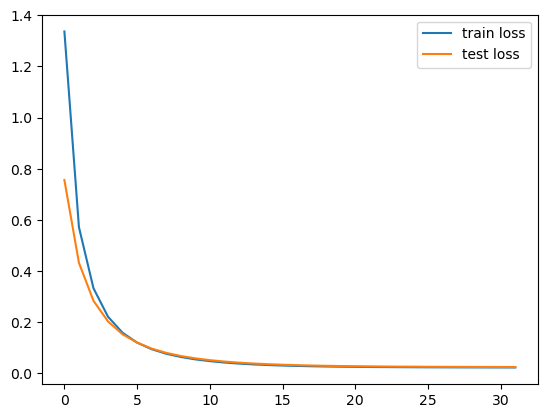

In [26]:
# 训练过程
lr = 0.03
num_epoches = 32
batch_size = 1024

net = get_net_fn(p, h, devc)
loss = get_loss_fn()
optimizer = get_optim_fn(net.parameters(), lr)
params, train_loss_list, test_loss_list = train(
    net,
    loss,
    optimizer,
    num_epoches,
    batch_size,
    train_iter,
    test_iter,
    eval_loss_fn,
)

plt.plot(train_loss_list, label="train loss")
plt.plot(test_loss_list, label="test loss")
plt.legend()
plt.show()